Форма массива эмбеддингов: (15, 2048)
Количество образцов: 15


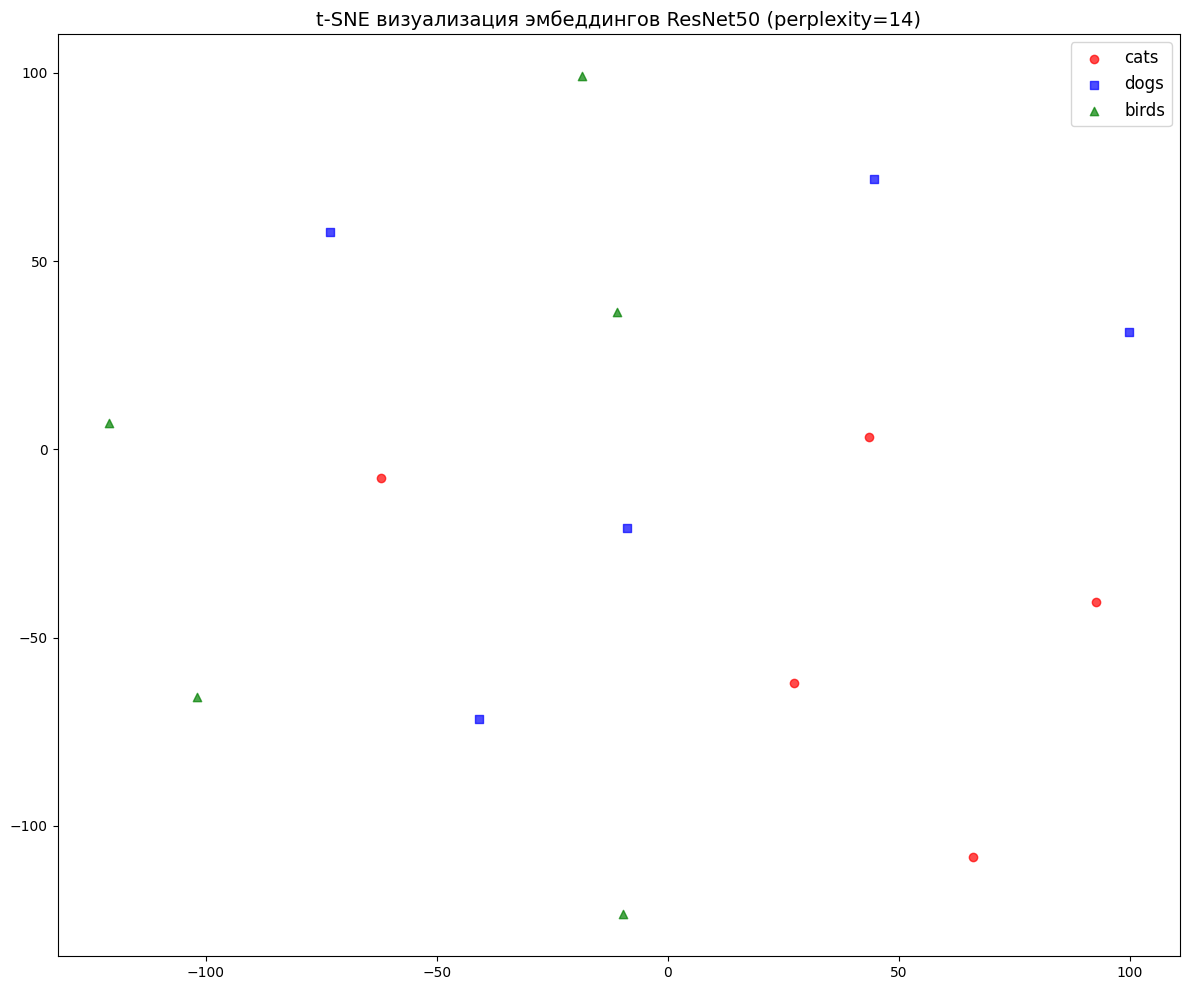

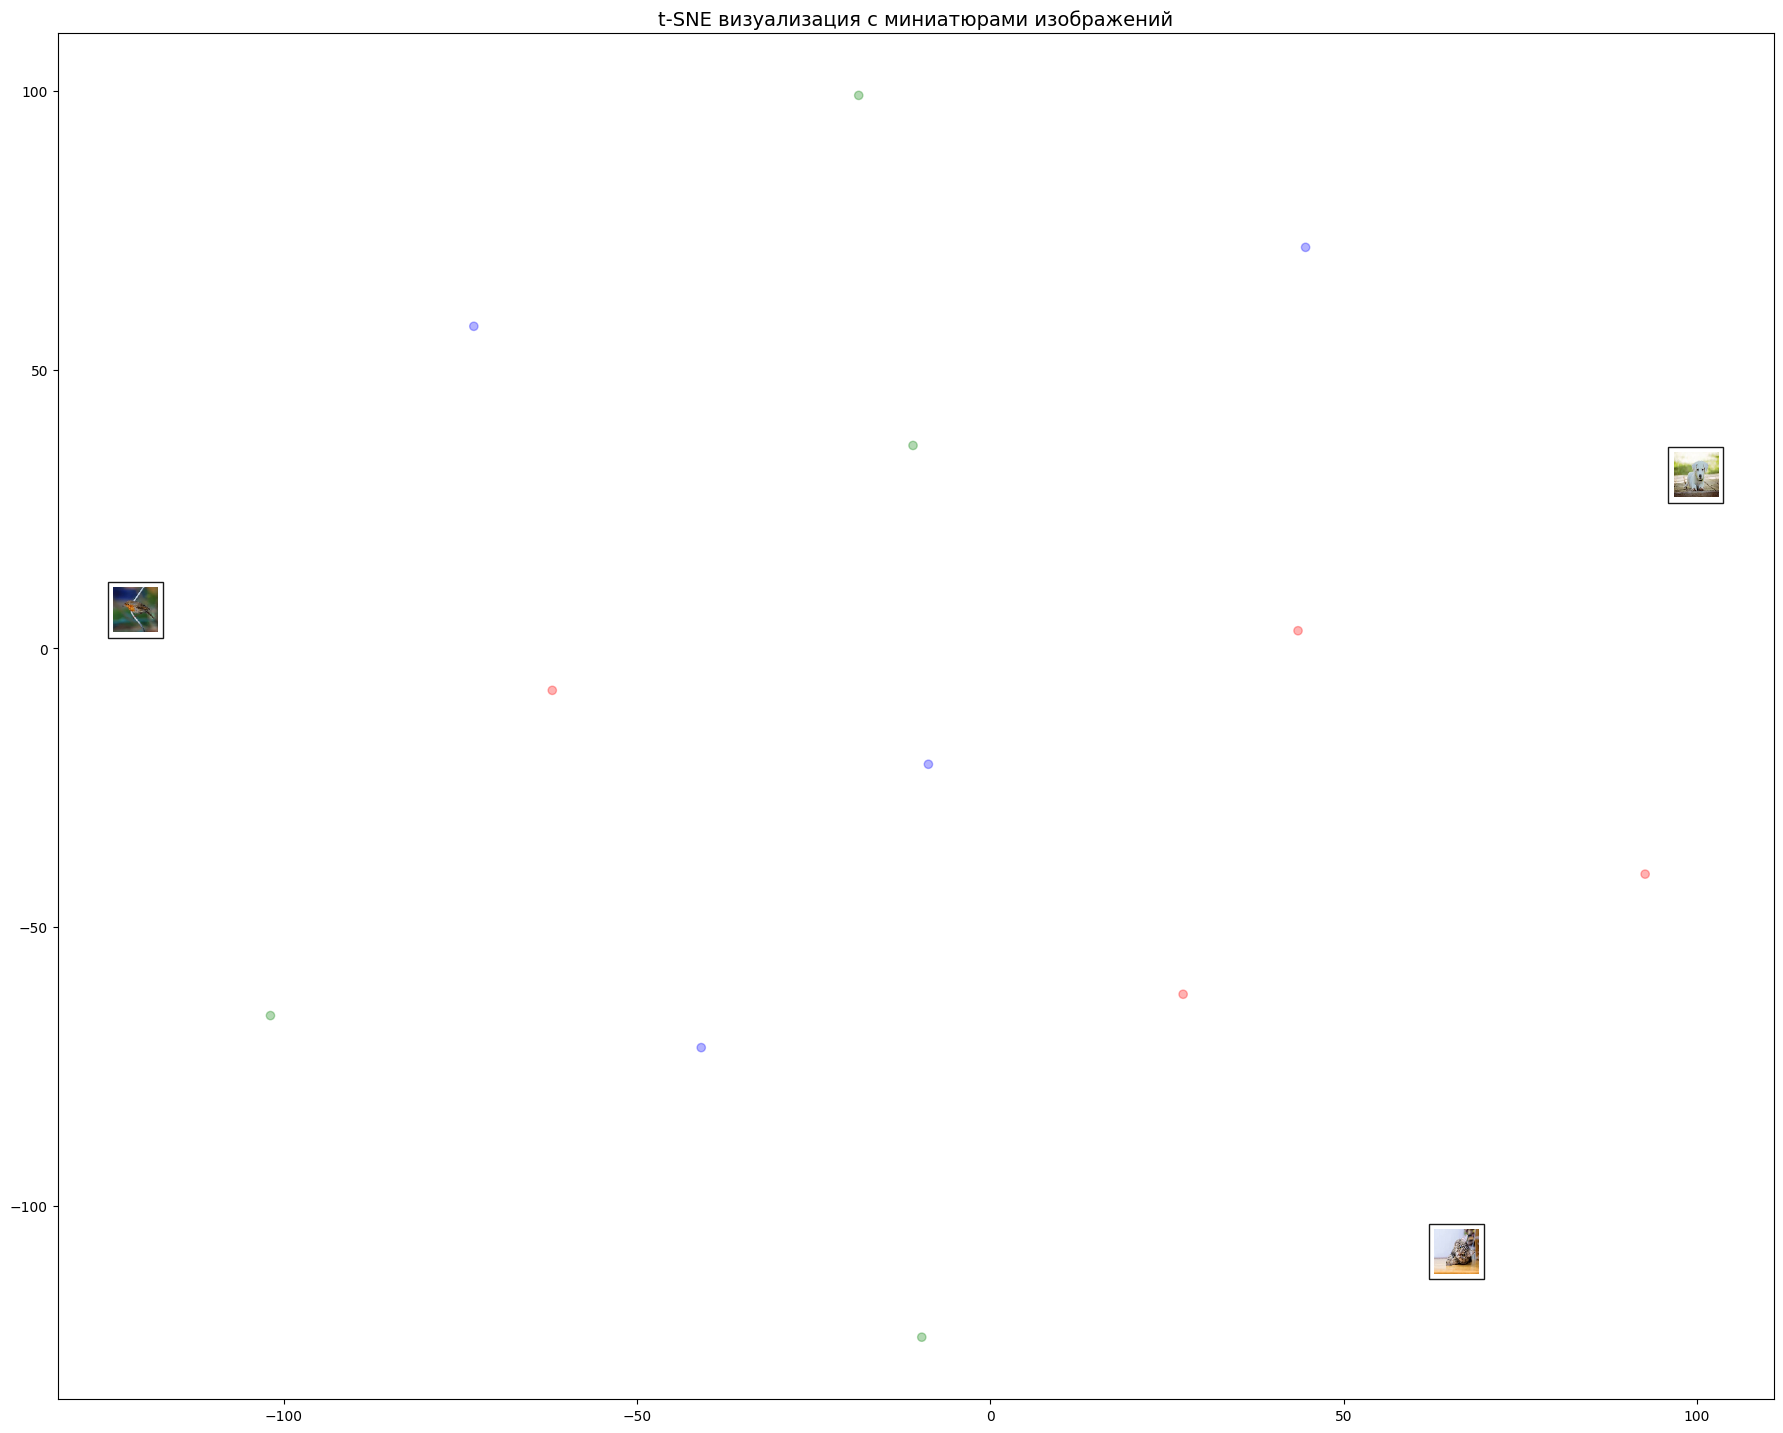

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import glob
import os
from matplotlib import offsetbox

# Загрузка предобученной модели без верхнего слоя классификации
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Функция для получения эмбеддингов изображения
def get_embedding(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    embedding = base_model.predict(x, verbose=0)
    return embedding[0]

# Предположим, у нас есть папки с изображениями разных классов
class_folders = ['cats', 'dogs', 'birds']
embeddings = []
labels = []
image_paths = []

# Получаем эмбеддинги для всех изображений
for class_idx, folder in enumerate(class_folders):
    image_files = glob.glob(os.path.join(folder, '*.jfif'))
    for img_path in image_files[:5]:  # Берем только первые 30 изображений для каждого класса
        try:
            emb = get_embedding(img_path)
            embeddings.append(emb)
            labels.append(class_idx)
            image_paths.append(img_path)
        except Exception as e:
            print(f"Ошибка обработки {img_path}: {e}")

# Преобразование в numpy массив
embeddings = np.array(embeddings)
print(f"Форма массива эмбеддингов: {embeddings.shape}")
print(f"Количество образцов: {len(embeddings)}")

# Автоматический подбор perplexity (не больше чем n_samples - 1)
n_samples = len(embeddings)
perplexity = min(30, n_samples - 1)  # Убедимся, что perplexity < n_samples

# Применение t-SNE для снижения размерности до 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, n_iter=3000)
embeddings_2d = tsne.fit_transform(embeddings)

# Визуализация с цветовой кодировкой классов
plt.figure(figsize=(12, 10))
colors = ['red', 'blue', 'green']
markers = ['o', 's', '^']
for i, class_name in enumerate(class_folders):
    indices = [j for j, label in enumerate(labels) if label == i]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], 
                c=colors[i], label=class_name, marker=markers[i], alpha=0.7)

plt.legend(fontsize=12)
plt.title(f't-SNE визуализация эмбеддингов ResNet50 (perplexity={perplexity})', fontsize=14)
plt.tight_layout()
plt.show()

# Интерактивная визуализация с отображением примеров изображений
def plot_with_images(embeddings_2d, images, labels, figsize=(20, 16), image_size=0.5):
    fig, ax = plt.subplots(figsize=figsize)
    colors = ['red', 'blue', 'green']
    
    # Отображаем точки
    scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                        c=[colors[label] for label in labels], alpha=0.3)
    
    # Отображаем миниатюры изображений для выбранных точек (каждой 5-й)
    shown_images = np.array([[1., 1.]])  # просто начальная точка
    for i in range(0, len(embeddings_2d), 5):
        # Отображаем изображение только если оно не слишком близко к уже отображенным
        dist = np.sum((embeddings_2d[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            continue
        shown_images = np.r_[shown_images, [embeddings_2d[i]]]
        
        try:
            # Загружаем и отображаем изображение
            img = image.load_img(images[i], target_size=(64, 64))
            img_data = image.img_to_array(img) / 255.0
            
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(img_data, zoom=image_size),
                embeddings_2d[i], bboxprops=dict(alpha=0.9))
            ax.add_artist(imagebox)
        except Exception as e:
            print(f"Не удалось загрузить изображение {images[i]}: {e}")
    
    plt.title('t-SNE визуализация с миниатюрами изображений', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_with_images(embeddings_2d, image_paths, labels)